# Gnomix Demo

This notebook takes you through the process of using the tool for local ancestry predictions both by training a model using your own reference panel and by using a pre-trained model. It then gives an example of how one might analyze the results.

### Loading packages

In [1]:
import numpy as np
import os
import pandas as pd

In [2]:
# Arguments
data_path        = "./demo/data/"
query_file       = data_path + "ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz"
genetic_map_file = data_path + "allchrs.b37.gmap"
reference_file   = data_path + "reference_1000g.vcf"
sample_map_file  = data_path + "1000g.smap"
chm              = "22"
phase            = "False"
output_basename  = "./demo/output"

## Training a model from scratch

Here we use the command line interface to train a model using a reference file, make inference on a query file and then write the results to the file *demo.msp.txv*. 

All the files are stored inside the */demo/data* folder **except for the query file and the reference file**. The query file we'll use is chromosome 22 from the 1000 genomes project which can be downloaded from ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/. We'll create the reference file from the query file in the next cell by subsetting the part of the query file that we know are single ancestry samples using the provided sample map (1000g.smap) with bcftools.

In [3]:
sample_map = pd.read_csv(sample_map_file, sep="\t")
samples = list(sample_map["#Sample"])
sample_file = data_path + "samples_1000g.tsv"
np.savetxt(sample_file, samples, delimiter="\t", fmt="%s")
subset_cmd = "bcftools view" + " -S " + sample_file + " -o " + reference_file + " " + query_file
print("Running in command line: \n\t", subset_cmd)
os.system(subset_cmd)

Running in command line: 
	 bcftools view -S ./demo/data/samples_1000g.tsv -o ./demo/data/reference_1000g.vcf ./demo/data/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz


Now we have everything we need to train the model,

In [4]:
train_cmd = " ".join(["python3 gnomix.py",
                      query_file, genetic_map_file, output_basename, chm, phase, reference_file, sample_map_file]) + \
            " > ./demo/training_log.txt"
print("Running in command line: \n\t", train_cmd)
os.system(train_cmd)

Running in command line: 
	 python3 gnomix.py ./demo/data/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz ./demo/data/allchrs.b37.gmap ./demo/output 22 False ./demo/data/reference_1000g.vcf ./demo/data/1000g.smap > ./demo/training_log.txt


## Using a pre-trained model

Let's now see how one can download some of our already trained models and use them for inference.

First we'll download the models,

In [5]:
!sh download_pretrained_models.sh

Download in progress...
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   2550      0 --:--:-- --:--:-- --:--:--  2550
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1949M  100 1949M    0     0   102M      0  0:00:19  0:00:19 --:--:--  107M
Expanding files...
pretrained_gnomix_models/
pretrained_gnomix_models/chr5/
pretrained_gnomix_models/chr5/chr5.bim
pretrained_gnomix_models/chr9/
pretrained_gnomix_models/chr9/chr9.bim
pretrained_gnomix_models/chr16/
pretrained_gnomix_models/chr16/model_chm_16.pkl
pretrained_gnomix_models/chr16/config.txt
pretrained_gnomix_models/chr16/chr16.bim
pretrained_gnomix_models/chr18/
pretrained_gnomix_models/chr18/config.txt
pretrained_gnomix_models/chr18/model_chm_18.pkl
pretrained_gnomix_models/chr18/c

Then we run the inference on the same query file as before. This should take around 5 minutes depending on your processors. Biggest part of it is actually just loading the query file and second biggest is writing the inference to disk.

In [8]:
path_to_model = "pretrained_gnomix_models/chr{}/model_chm_{}.pkl".format(chm, chm)

# defining and executing the command
run_cmd =  "python3 gnomix.py"
cmd = " ".join([run_cmd, query_file, output_basename, chm, phase, path_to_model]) + \
      " > ./demo/pretrained_log.txt"

print("Running in command line: \n\t", cmd)
os.system(cmd)

Running in command line: 
	 python3 gnomix.py ./demo/data/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz ./demo/output 22 False pretrained_gnomix_models/chr22/model_chm_22.pkl > ./demo/pretrained_log.txt


## Analyzing results

### Reading from the ouput

Here we read the results from the output file into a dataframe

In [9]:
# read the output file into a dataframe
output_file = output_basename+"/query_results.msp"
msp_df = pd.read_csv(output_file, sep="\t", skiprows=[0])
msp_df

,#chm,spos,epos,sgpos,egpos,n snps,HG00096.0,HG00096.1,HG00097.0,HG00097.1,...,NA21137.0,NA21137.1,NA21141.0,NA21141.1,NA21142.0,NA21142.1,NA21143.0,NA21143.1,NA21144.0,NA21144.1
0,22,16854565,16928785,1.58688,1.69071,14868,0,0,0,0,...,4,4,4,4,4,4,4,4,4,4
1,22,16928836,17041764,1.69072,1.71361,2962,0,0,0,0,...,4,4,4,4,4,4,4,4,4,4
2,22,17042030,17135909,1.71375,1.84303,3041,0,0,0,0,...,4,4,4,4,4,4,4,4,4,4
3,22,17135918,17292156,1.84303,2.16863,2655,0,0,0,0,...,4,4,4,4,4,4,4,4,4,4
4,22,17292258,17374057,2.16868,2.41088,2636,0,0,0,0,...,4,4,4,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,22,50769029,50863560,73.43761,73.50433,3051,0,0,0,0,...,4,4,4,4,4,4,4,4,4,4
366,22,50863902,50937462,73.50434,73.75547,3364,0,0,0,0,...,4,4,4,4,4,4,4,4,4,4
367,22,50937521,51012775,73.75558,73.83819,2882,0,0,0,0,...,4,4,4,4,4,4,4,4,4,4
368,22,51012854,51106555,73.83822,73.96752,3006,0,0,0,0,...,4,4,4,4,4,4,4,4,4,4


## Measuring performance

In [10]:
from scipy import stats
from sklearn.metrics import confusion_matrix

from src.postprocess import get_samples_from_msp_df
from src.visualization import plot_cm, plot_chm

%load_ext autoreload
%autoreload 2

In [11]:
sample_map = pd.read_csv(sample_map_file, sep="\t")

Here we predict **single ancestry** for each individual by creatoing a dataframe containing only one label prediction for each individual. We do so simply by taking the mode of the local predictions for each individual. 

In [12]:
# reading the sample-ids
query_samples = get_samples_from_msp_df(msp_df)

# reading predictions for each of the intervals
pred_labels = (np.array(msp_df)[:,6:].T).astype(int)

# reducing it to only 1 of maternal/paternal prediction
single_ind_idx = np.arange(0,len(query_samples)*2,2)
pred_labels_single_ind = pred_labels[single_ind_idx,:]

# predicting single ancestry by taking mode of local predictions for each individual
y_pred = stats.mode(pred_labels_single_ind,axis=1)[0].squeeze() 

# get model population order from first line of file and convert from numeric predictions
with open(output_file, "r") as f:
    pop = np.array([p.split("=")[0] for p in f.readline().split()[2:]])
pred_pop = [pop[pop_ind] for pop_ind in y_pred]

# put it together in dataframe
pred_df = pd.DataFrame({"Sample": query_samples, "Prediction": pred_pop})
pred_df

,Sample,Prediction
0,HG00096,EUR
1,HG00097,EUR
2,HG00099,EUR
3,HG00100,EUR
4,HG00101,EUR
...,...,...
2499,NA21137,SAS
2500,NA21141,SAS
2501,NA21142,SAS
2502,NA21143,SAS


We can read the true labels from the sample map file and add them to the dataframe. The true ancestry labels (not only single ancestry individuals) are stored in the meta data file *demo/data/1000g.meta*.

In [13]:
# adding the true labels
sample_map_file = "./demo/data/1000g.meta" # find the true labels in the sample map file
sample_map_df = pd.read_csv(sample_map_file, sep="\t")
true_labels_df = sample_map_df[["Sample", "Superpopulation code"]]
true_labels_df.columns = ["Sample", "Population"]
pred_df = pred_df.merge(true_labels_df)
pred_df

,Sample,Prediction,Population
0,HG00096,EUR,EUR
1,HG00097,EUR,EUR
2,HG00099,EUR,EUR
3,HG00100,EUR,EUR
4,HG00101,EUR,EUR
...,...,...,...
1215,NA20822,EUR,EUR
1216,NA20826,EUR,EUR
1217,NA20827,EUR,EUR
1218,NA20828,EUR,EUR


And then compare the predictions with the true labels

In [14]:
# Getting the prediction accuracy
acc = np.mean(pred_df.Population == pred_df.Prediction)
print("Accuracy for single ancestry: ", acc*100, "%", sep="")

Accuracy for single ancestry: 100.0%


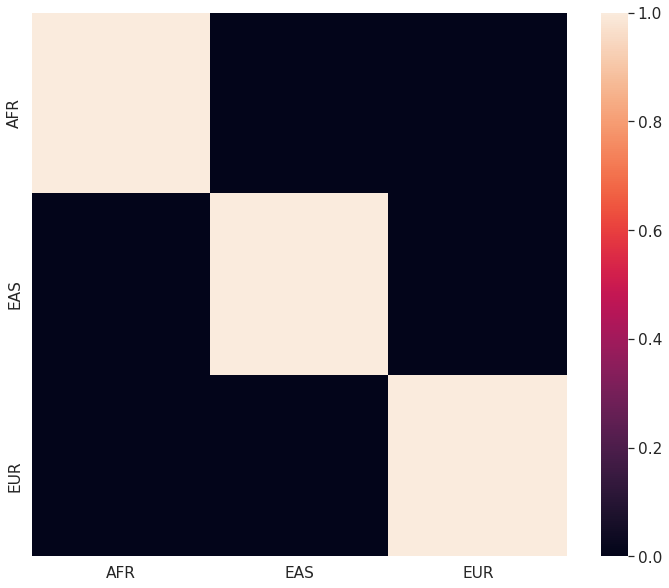

In [15]:
# creating and visualizing the confusion matrix
labs = np.unique(pred_df[['Population', 'Prediction']])
cm = confusion_matrix(pred_df.Population, pred_df.Prediction, labels=labs)
cm_plot = plot_cm(cm, normalize=True, labels=labs)
cm_plot.figure.savefig('./demo/imgs/single_ancestry_confusion_matrix.png')

## Plotting the prediction

We can use the results to plot the predictions along the chromosome. Here is an example of how to use [Tagore](https://pypi.org/project/tagore/#usage) for that purpose. Here we visualize one individual and only for chromosome 22. See **plot_chm** from *src/visualization.py* for more details of how to to that.

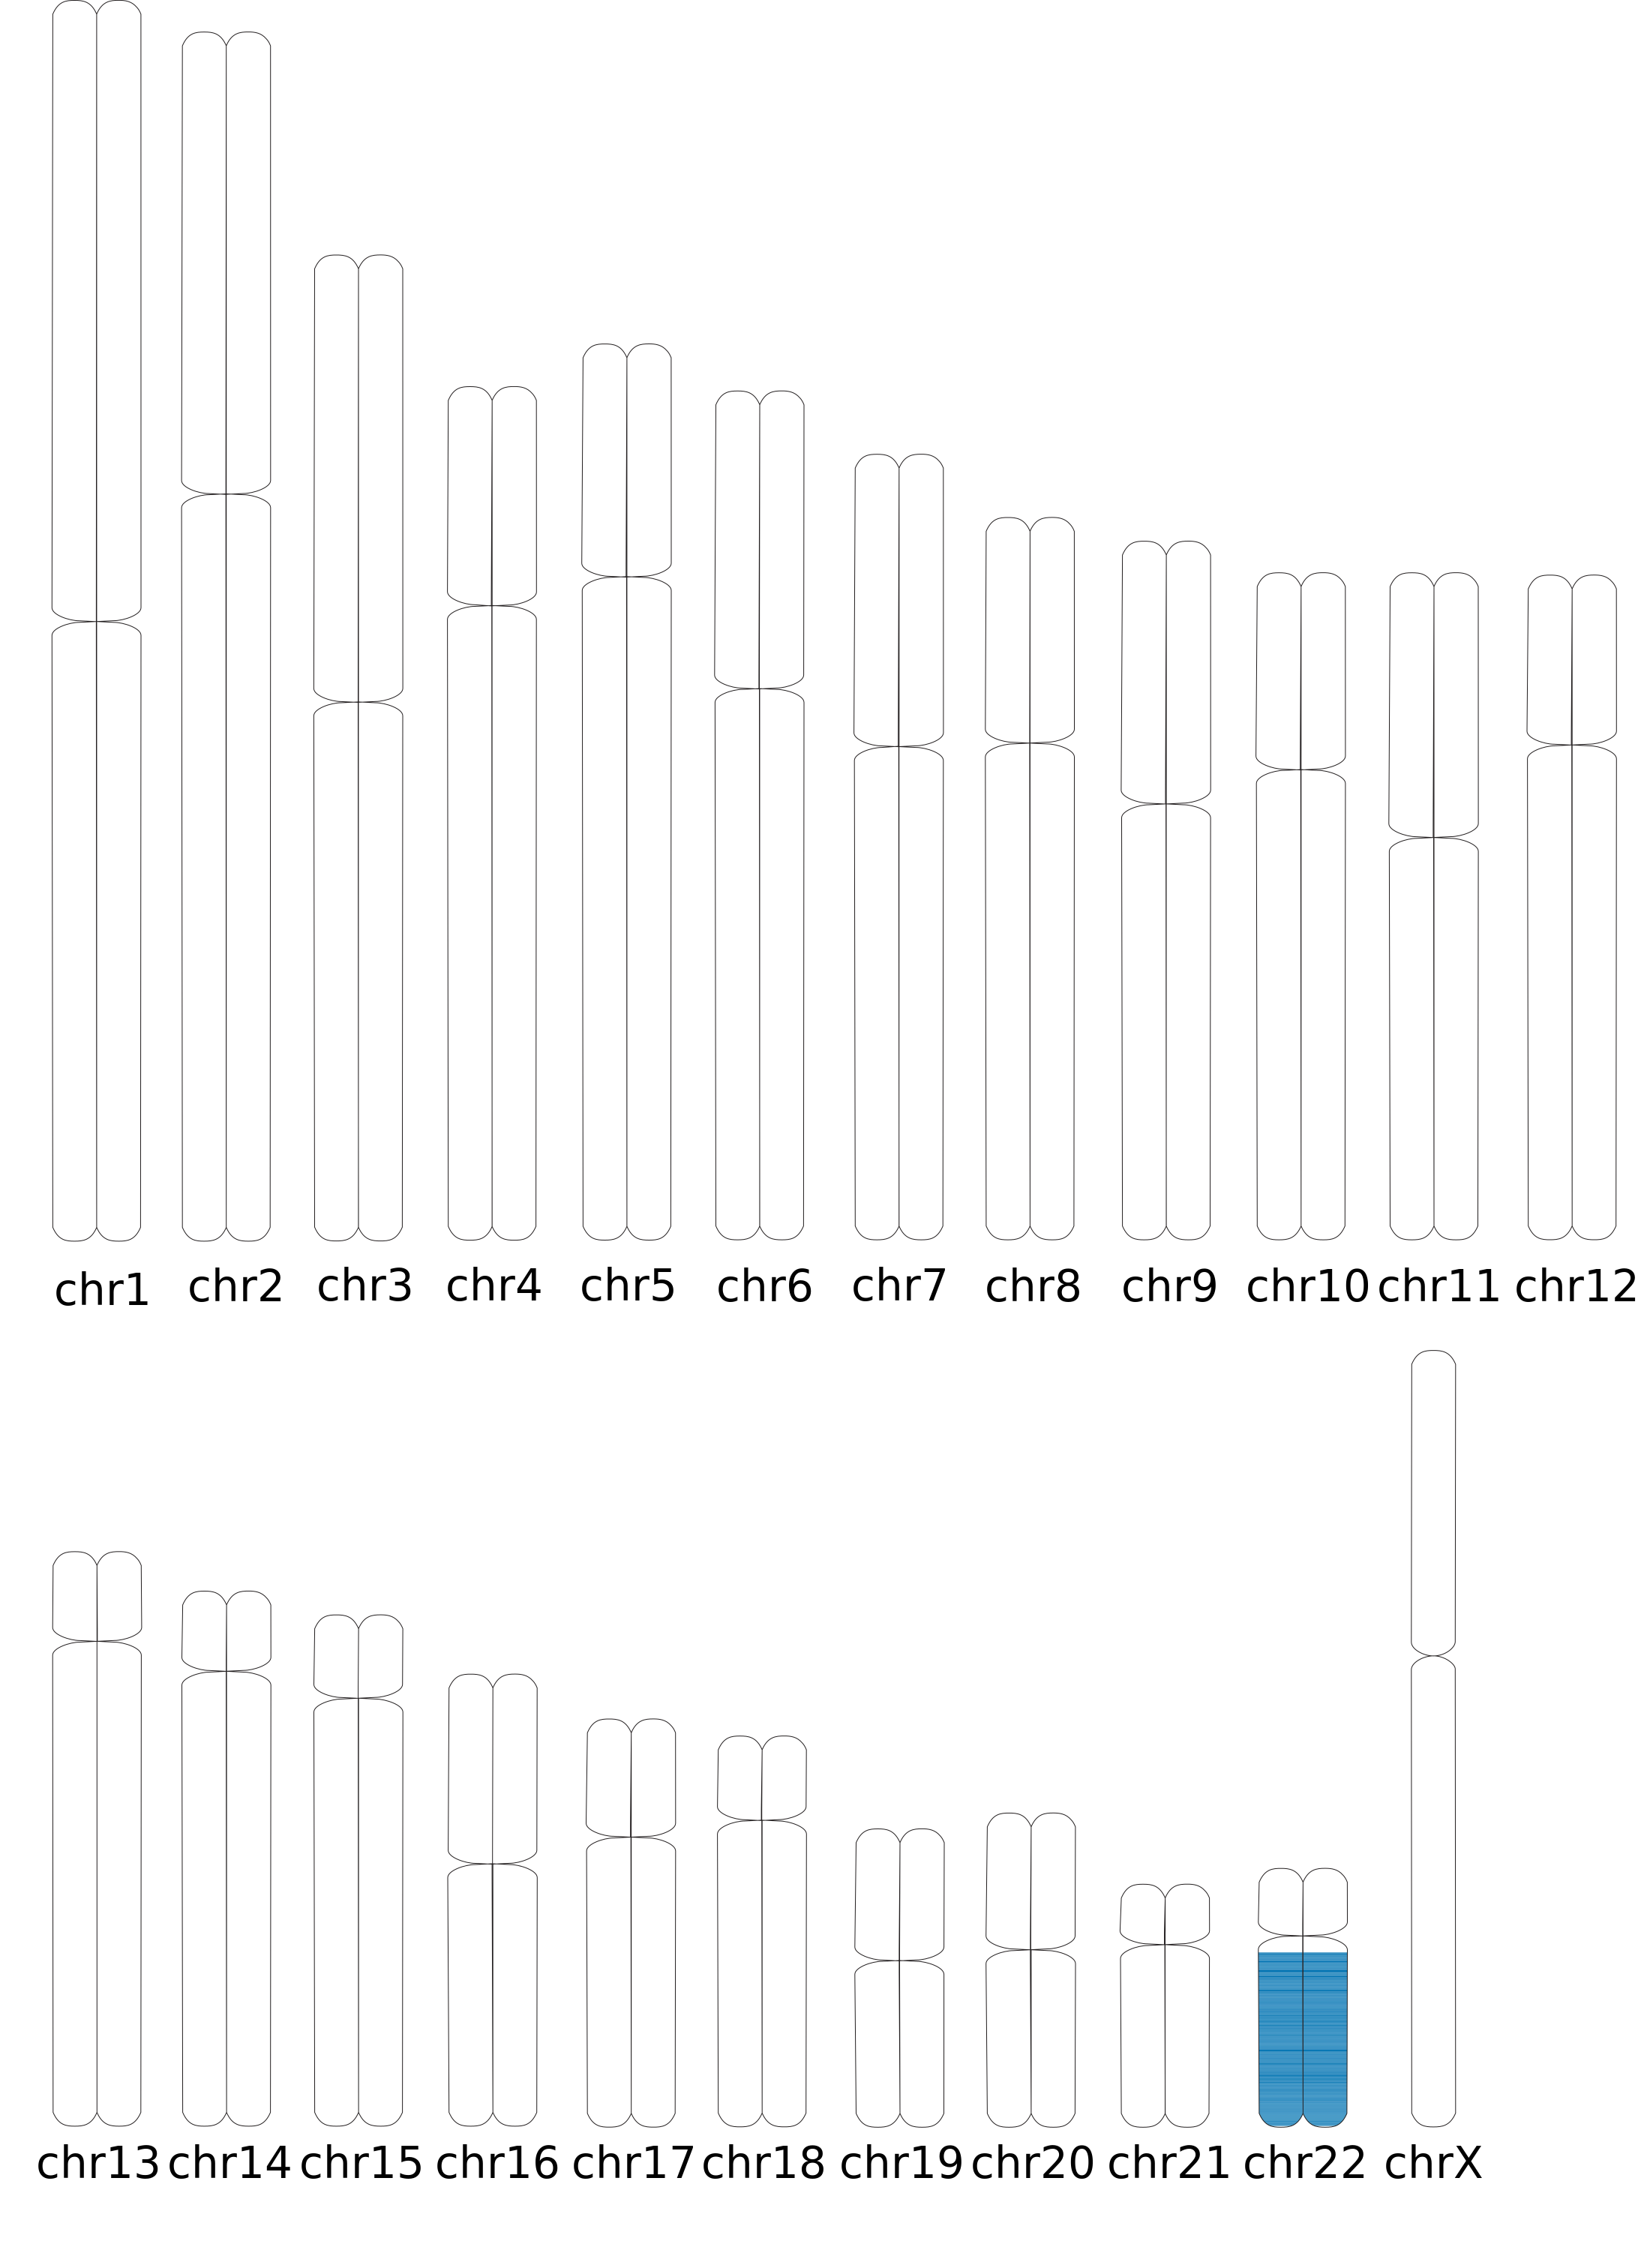

In [16]:
from IPython.display import Image

sample_id = "HG00096" # looking at just one random sample
img_name = "./demo/imgs/chm_img"
plot_chm(sample_id, msp_df, img_name=img_name)
Image(filename=img_name+".png")